In [1]:
import creds
import matplotlib.pyplot as plt
from cointegration.funcs import * 
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sps
from statsmodels.tsa.stattools import adfuller as adf
import scipy.optimize as spo

tok = creds.token_ro_all

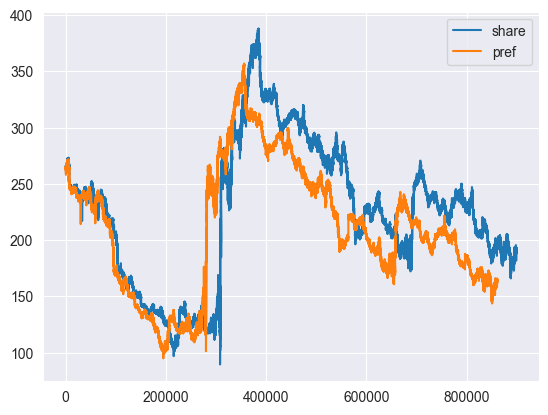

In [2]:
ticker = 'SBER'
share = pd.read_csv(f'../data/shares_data/companies/{ticker}.csv')
pref = pd.read_csv(f'../data/shares_data/companies_pref/{ticker}P.csv')

plt.plot(share['close'], label='share')
plt.plot(pref['close'], label='pref')
plt.legend()

##### Matching

Time Series1:  4.5% is missing (899121 ==> 859080)
Time Series2:  0.2% is missing (860938 ==> 859080)


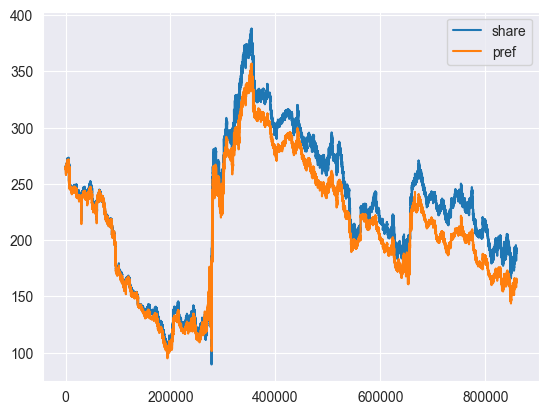

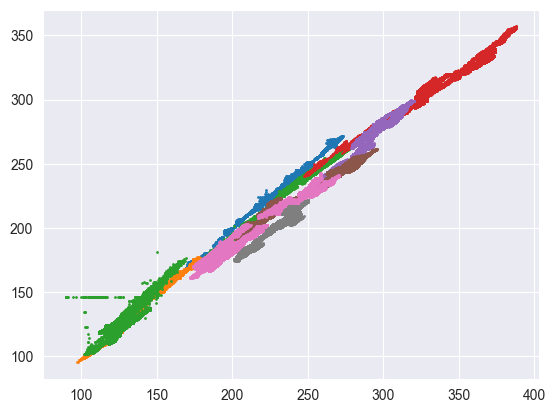

In [3]:
share, pref = match_ts(share, pref)

plt.plot(share['close'], label='share')
plt.plot(pref['close'], label='pref')
plt.legend()
plt.show()


for N in range(8):
    plt.plot(share['close'][N * 10**5 : (N+1) * 10**5], pref['close'][N * 10**5: (N+1)*10**5], 'o', markersize = 1)
    # plt.xlim(100, 400)
    # plt.ylim(100, 350)
plt.show()

##### Removing linear trend from sample data and making STD bands

[2.57342573 0.13951242]


(-5.0, 17.0)

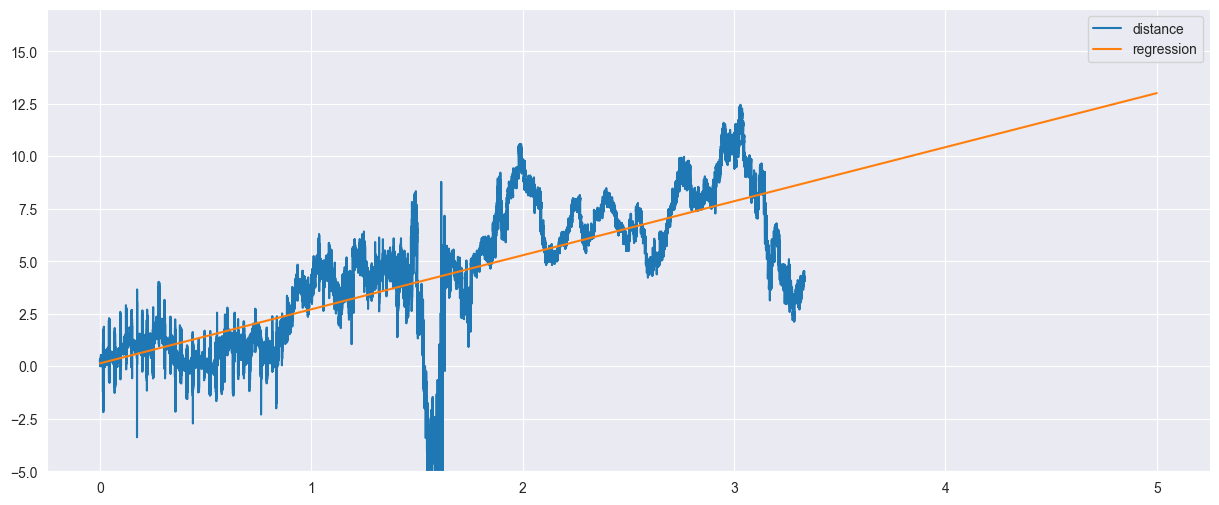

In [4]:
dist = 100*(share['close'] - pref['close']) / share['close']
cut = int(2*len(dist)/3)
dist_check = dist[cut:]

dist = dist[:cut]

dist_df = pd.DataFrame()
dist_df['dist'] = dist
dist_df['time'] = np.linspace(0, 5*2/3, cut)

coefs = np.polyfit(dist_df['time'], dist_df['dist'], 1)
print(coefs)
lin = np.poly1d(coefs)
x_ax = np.linspace(0, 5, 100)

plt.figure(figsize=(15, 6))
plt.plot(dist_df['time'], dist_df['dist'], label='distance')
plt.plot(x_ax, lin(x_ax), label='regression')
plt.legend()
plt.ylim(-5, 17)

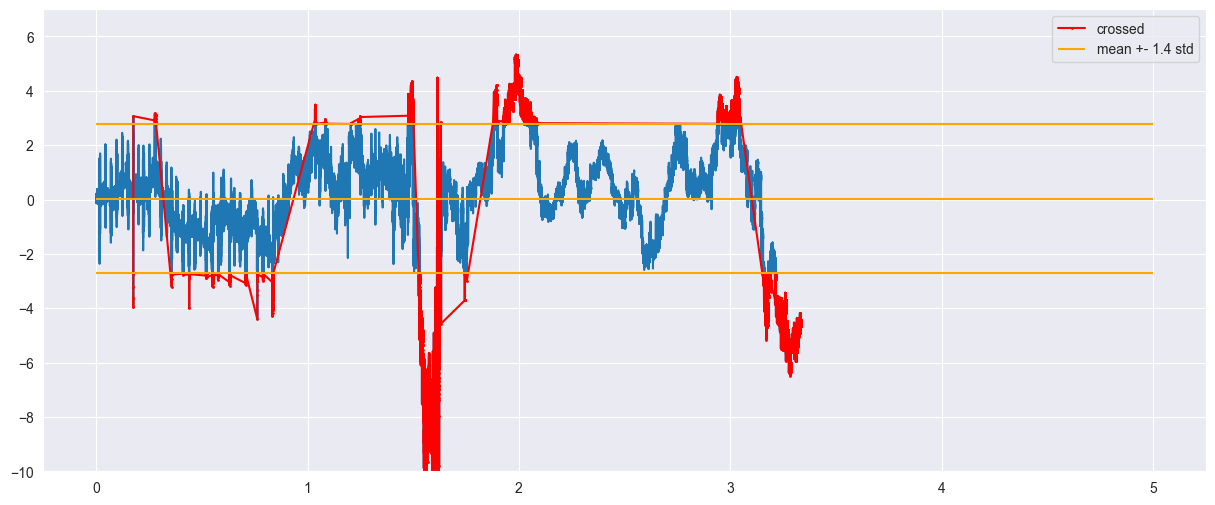

In [5]:
dist_df['demeaned'] = dist_df['dist'] - lin(dist_df['time'])
clipped = dist_df.clip(dist_df['demeaned'].quantile(0.02), dist_df['demeaned'].quantile(0.98), axis=1)
mean = clipped['demeaned'].mean()
std = clipped['demeaned'].std()
mul = 1.4
cross = dist_df.loc[(dist_df['demeaned'] > mean+std*mul) | (dist_df['demeaned'] < mean-std*mul)]

plt.figure(figsize=(15, 6))
plt.plot(dist_df['time'], dist_df['demeaned'])
plt.plot(cross['time'], cross['demeaned'], label='crossed', color='red', marker='o',markersize=1)
plt.hlines([mean, mean-std*mul, mean+std*mul], 0, 5, label=f'mean +- {mul} std', colors='orange')
plt.plot()
plt.legend()
plt.ylim(-10, 7)
plt.show()

##### Checking out of sample data with params from sample

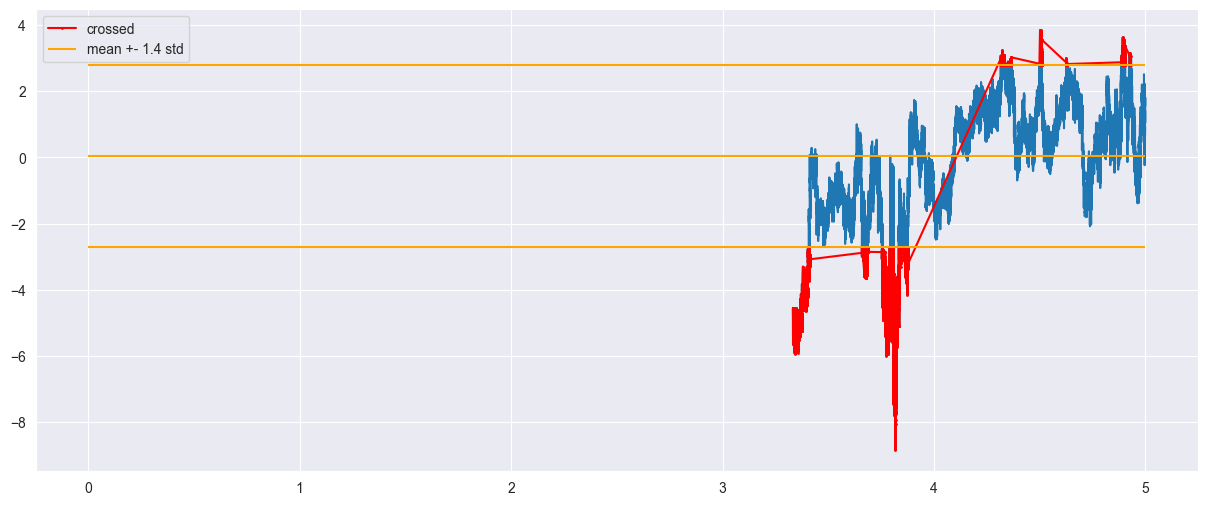

In [6]:
check_df = pd.DataFrame()
check_df['dist'] = dist_check
check_df['time'] = np.linspace(5*2/3, 5, len(dist_check))
check_df['demeaned'] = check_df['dist'] - lin(check_df['time'])
cross_check = check_df.loc[(check_df['demeaned'] > mean+std*mul) | (check_df['demeaned'] < mean-std*mul)]

plt.figure(figsize=(15, 6))
plt.plot(check_df['time'], check_df['demeaned'])
plt.plot(cross_check['time'], cross_check['demeaned'], label='crossed', color='red', marker='o', markersize=1)
plt.hlines([mean, mean-std*mul, mean+std*mul], 0, 5, label=f'mean +- {mul} std', colors='orange')
plt.plot()
plt.legend()
# plt.ylim(-5, 7)

##### Correlation Testing

<Axes: >

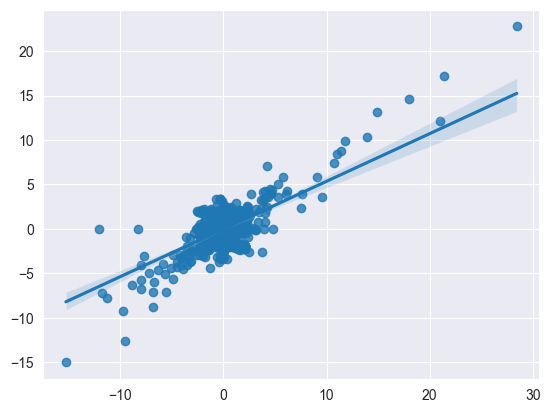

In [7]:
share_rets = np.diff(share.close)
pref_rets = np.diff(pref.close)

sns.regplot(x=share_rets[::10], y=pref_rets[::10])

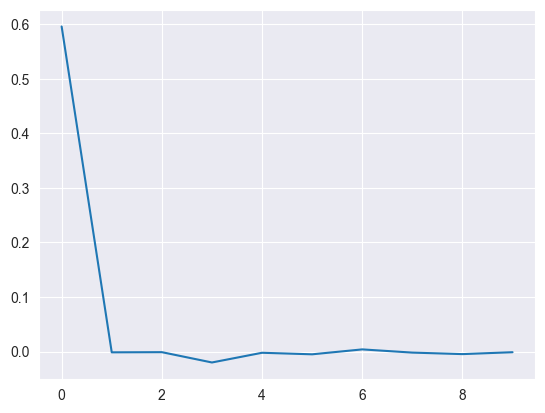

In [8]:
corr_list = []
for i in range(0,10):
    temp = np.roll(pref_rets, i)
    corr_list.append(sps.pearsonr(x=share_rets, y=temp)[0])

plt.plot(corr_list)

## Cointegraition testing

a = 12.885690062608631, b = 0.8941354141402276


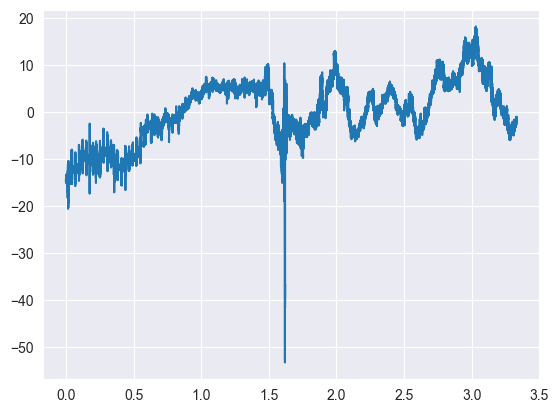

In [9]:
cut = int(2* len(share.close)/3)
share_sample = share.close[:cut]
pref_sample = pref.close[:cut]
time_sample = np.linspace(0, 5*2/3, cut)

res = sps.linregress(share_sample, pref_sample)
err = res.intercept + res.slope*share_sample - pref_sample
print(f'a = {res.intercept}, b = {res.slope}')
plt.plot(time_sample, err)

In [10]:
def df_stat(ts):
    res = sps.linregress(ts[:-1], np.diff(ts))
    return res.slope / res.stderr

df_stat(err)

-20.280112644524674

##### With detrending

In [11]:
adf(err[::2], regression='ct', regresults=True)

(-5.619495343569357,
 1.3317589675159448e-05,
 {'1%': -3.9588016245770827,
  '5%': -3.4105053366270597,
  '10%': -3.1270590320490412},
 <statsmodels.stats.diagnostic.ResultsStore at 0x2b9621610>)

In [12]:
A = np.array((np.ones_like(time_sample), time_sample, share_sample))
print(A.shape)
lp = pref_sample

res = np.linalg.lstsq(A.T, lp, rcond=None)
print(res[0])

(3, 572720)
[14.44535395 -5.27047264  0.92533956]


In [13]:
a, t, b = res[0]
err = pref_sample - b*share_sample - t*time_sample - a
df_stat(err)

-28.351015644065924

##### Optimization

In [14]:
def cost(p):
    a = np.mean(pref_sample - p[0]*share_sample - p[1]*time_sample)
    err = pref_sample - p[0]*share_sample - p[1]*time_sample - a
    return df_stat(err)

res = spo.minimize(cost, x0=(0.9, 0.))
print(res)
b, t = res.x

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -28.36708970144626
        x: [ 9.277e-01 -5.338e+00]
      nit: 14
      jac: [ 8.416e-05  1.168e-05]
 hess_inv: [[ 6.220e-04  2.434e-04]
            [ 2.434e-04  1.020e-03]]
     nfev: 165
     njev: 51


-28.36708970144626


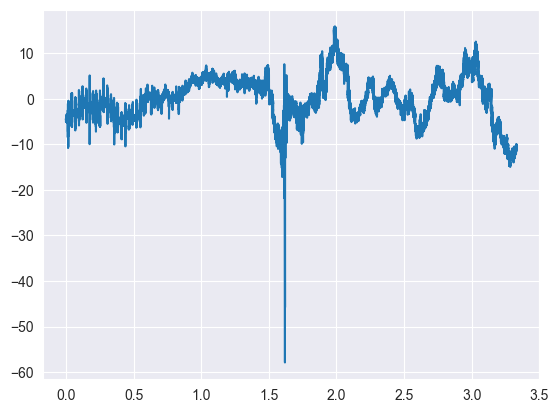

In [15]:
a = np.mean(pref_sample - b*share_sample - t*time_sample)
err = pref_sample - b*share_sample - t*time_sample - a
print(df_stat(err))
plt.plot(time_sample, -err)

## Mid Results

OLS and simple optimization give similar results, but they are not dynamic and rolling windows do not help for every stock.

##### OK: 
* CNTL
* KZOS
* PMSB
* KAZT
* BANE

##### TREND:
* SBER + quake
* TATN + quake
* SNGS
* RTKM
* NKNC

##### ???:
* TGKB 
* LSNG 
* MTLR
* LNZL 

Some pairs are quite well imprinted, but they are illiquid, some clearly have a trend or a change of modes

## Therefore: 
* Kalman filter should be tested
* Variant for costs optimization is Portfolio of integrated stocks with balancing
* It is possible to model the spread by a CIR process with mean reversal (for backtest and optimisation)
* Look at the liquidity and spread behavior on divs dates and different times of the day and even at the end of the week


# Kalman Filter